## Importando bibliotecas necesarias

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

## Carga de datos

In [30]:
dataset = pd.read_excel('../resources/2_preprocessed/dataset_completo.xlsx')
dataset['Fecha'] = pd.to_datetime(dataset['Fecha'])
dataset.set_index('Fecha', inplace=True)

## Visualización inicial

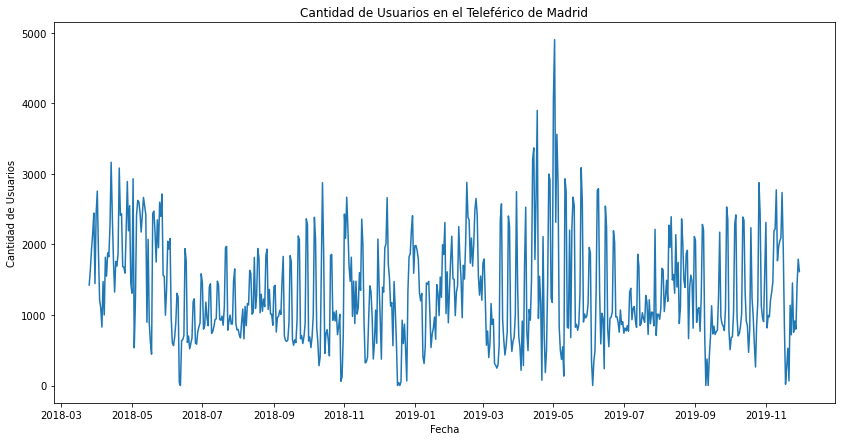

In [31]:
plt.figure(figsize=(14,7))
plt.plot(dataset['CantidadUsuarios'])
plt.title("Cantidad de Usuarios en el Teleférico de Madrid")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Usuarios")
plt.show()

## Descomposición de la serie temporal con STL

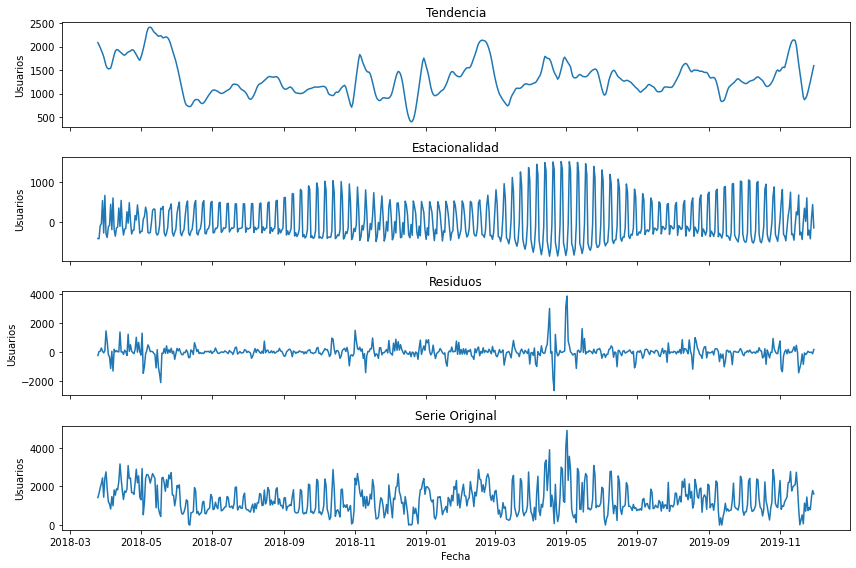

In [32]:
## Descomposición de la serie temporal con STL
stl = STL(dataset['CantidadUsuarios'], seasonal=13, robust=True, period=7)
result = stl.fit()

# Crear una figura y un conjunto de subtramas
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 8), sharex=True)

# Tendencia
ax1.plot(result.trend)
ax1.set_title('Tendencia')
ax1.set_ylabel('Usuarios')

# Estacionalidad
ax2.plot(result.seasonal)
ax2.set_title('Estacionalidad')
ax2.set_ylabel('Usuarios')

# Residuos
ax3.plot(result.resid)
ax3.set_title('Residuos')
ax3.set_ylabel('Usuarios')

# Serie original
ax4.plot(dataset['CantidadUsuarios'])
ax4.set_title('Serie Original')
ax4.set_ylabel('Usuarios')
ax4.set_xlabel('Fecha')

# Mostrar todo en una figura
plt.tight_layout()
plt.show()

## Definición de funciones

In [33]:
# Detectar outliers usando el IQR
def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

In [34]:
# Tratamiento de outliers usando la estacionalidad
def treat_outliers_with_seasonality(data, seasonal_data, outliers):
    data_corrected = data.copy()
    for index in outliers.index:
        data_corrected.loc[index] = seasonal_data.loc[index]
    return data_corrected

In [35]:
def treat_outliers_with_residuals(original_data, resid_data):
    q1 = resid_data.quantile(0.25)
    q3 = resid_data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers_indices = resid_data[(resid_data < lower_bound) | (resid_data > upper_bound)].index
    
    corrected_data = original_data.copy()
    for index in outliers_indices:
        corrected_value = original_data.loc[index] - resid_data.loc[index] + resid_data.median()
        corrected_data.loc[index] = corrected_value

    return corrected_data

In [36]:
def treat_outliers_with_trend(original_data, trend_data):
    difference = original_data - trend_data
    q1 = difference.quantile(0.25)
    q3 = difference.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers_indices = difference[(difference < lower_bound) | (difference > upper_bound)].index
    
    corrected_data = original_data.copy()
    for index in outliers_indices:
        corrected_value = trend_data.loc[index]
        corrected_data.loc[index] = corrected_value

    return corrected_data


In [37]:
def treat_outliers_with_median(data, outliers, window=3):
    data_corrected = data.copy()
    for index in outliers.index:
        # Determinar el rango del vecindario utilizando Timedelta para ventanas de tiempo
        start = max(data.index[0], index - pd.Timedelta(days=window))
        end = min(data.index[-1], index + pd.Timedelta(days=window))
        # Calcular la mediana del vecindario excluyendo el valor del outlier
        neighborhood = data.loc[start:end]
        neighborhood = neighborhood.drop(index)
        median_value = neighborhood.median()
        # Reemplazar el outlier con la mediana del vecindario
        data_corrected.loc[index] = median_value + data.loc[index] * 0.3
    return data_corrected

## Visualización de outliers

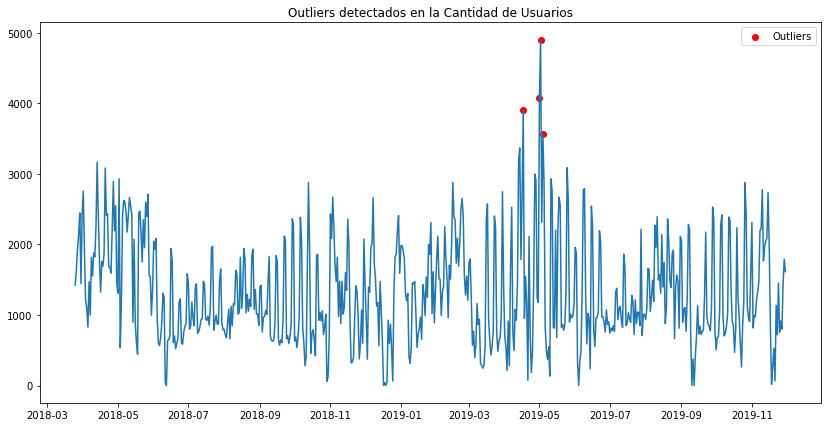

In [38]:
outliers = detect_outliers_iqr(dataset['CantidadUsuarios'])

plt.figure(figsize=(14,7))
plt.plot(dataset['CantidadUsuarios'])
plt.scatter(outliers.index, outliers.values, color='red', label='Outliers')
plt.title("Outliers detectados en la Cantidad de Usuarios")
plt.legend()
plt.show()

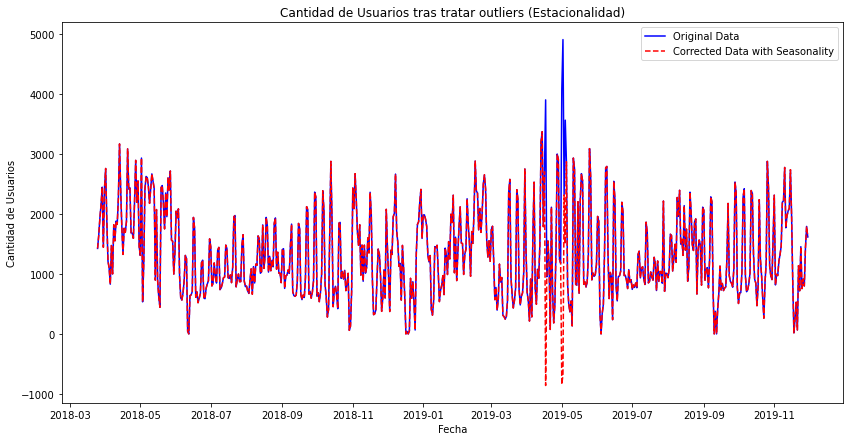

In [39]:
## Tratamiento de outliers
# Usando la estacionalidad
corrected_data_seasonality = treat_outliers_with_seasonality(dataset['CantidadUsuarios'], result.seasonal, outliers)

plt.figure(figsize=(14,7))
plt.plot(dataset.index, dataset['CantidadUsuarios'], label='Original Data', color='blue')
plt.plot(dataset.index, corrected_data_seasonality, label='Corrected Data with Seasonality', color='red', linestyle='--')
plt.title("Cantidad de Usuarios tras tratar outliers (Estacionalidad)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Usuarios")
plt.legend()
plt.show()


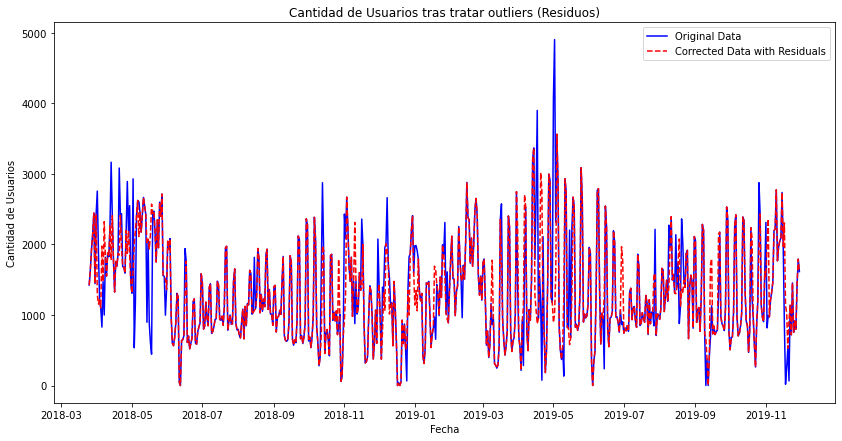

In [40]:
# Usando los residuos
corrected_data_residuals = treat_outliers_with_residuals(dataset['CantidadUsuarios'], result.resid)

plt.figure(figsize=(14,7))
plt.plot(dataset.index, dataset['CantidadUsuarios'], label='Original Data', color='blue')
plt.plot(dataset.index, corrected_data_residuals, label='Corrected Data with Residuals', color='red', linestyle='--')
plt.title("Cantidad de Usuarios tras tratar outliers (Residuos)")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Usuarios")
plt.legend()
plt.show()

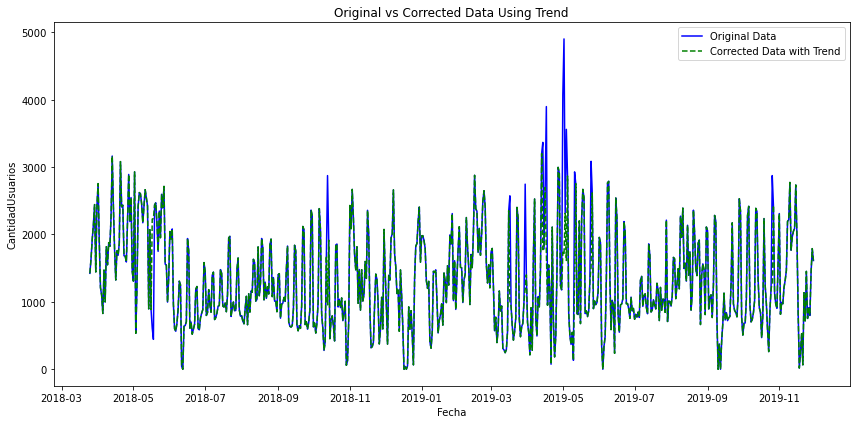

In [41]:
corrected_data_trend = treat_outliers_with_trend(dataset['CantidadUsuarios'], result.trend)

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['CantidadUsuarios'], label='Original Data', color='blue')
plt.plot(dataset.index, corrected_data_trend, label='Corrected Data with Trend', color='green', linestyle='--')
plt.legend()
plt.title('Original vs Corrected Data Using Trend')
plt.xlabel('Fecha')
plt.ylabel('CantidadUsuarios')
plt.tight_layout()
plt.show()


## Tratado final de la serie temporal

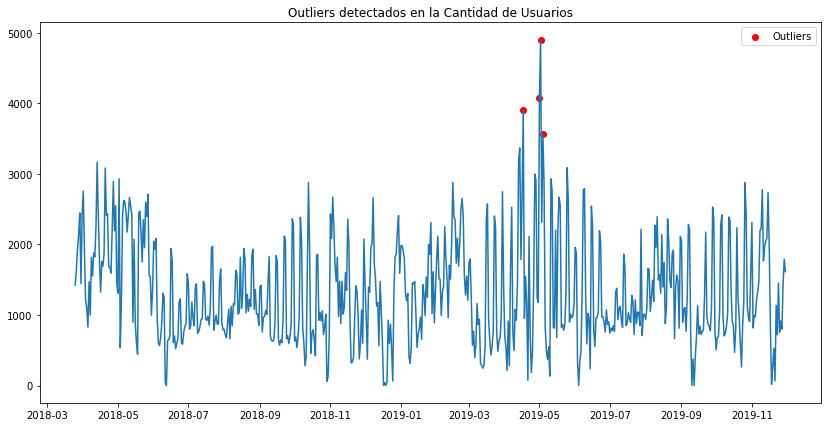

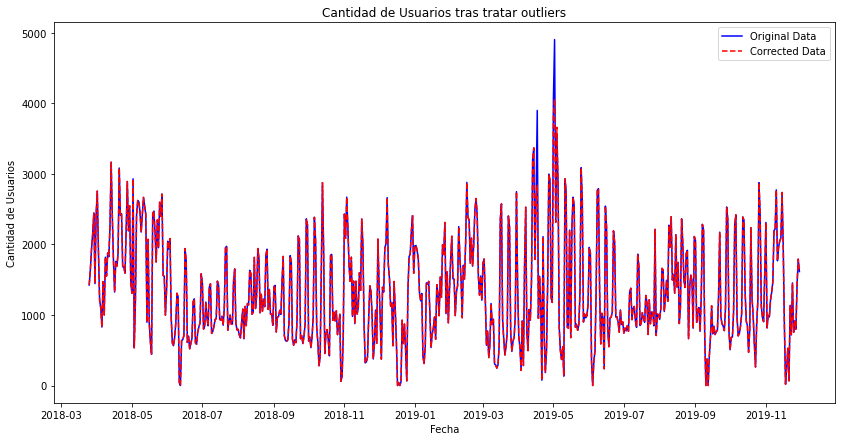

Dataset corregido guardado en: ../resources/3_treated_outlier/dataset_completo.xlsx


In [42]:
# Detectar outliers en la serie original
outliers = detect_outliers_iqr(dataset['CantidadUsuarios'])

# Visualización de outliers
plt.figure(figsize=(14,7))
plt.plot(dataset['CantidadUsuarios'])
plt.scatter(outliers.index, outliers.values, color='red', label='Outliers')
plt.title("Outliers detectados en la Cantidad de Usuarios")
plt.legend()
plt.show()

# Aplicar tratamiento de outliers
corrected_data_median = treat_outliers_with_median(dataset['CantidadUsuarios'], outliers)

# Guardar el dataset corregido
dataset_corrected = dataset.copy()
dataset_corrected['CantidadUsuarios'] = corrected_data_median
output_path = '../resources/3_treated_outlier/dataset_completo.xlsx'
dataset_corrected.to_excel(output_path)

# Visualización de los datos corregidos
plt.figure(figsize=(14,7))
plt.plot(dataset.index, dataset['CantidadUsuarios'], label='Original Data', color='blue')
plt.plot(dataset.index, corrected_data_median, label='Corrected Data', color='red', linestyle='--')
plt.title("Cantidad de Usuarios tras tratar outliers")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Usuarios")
plt.legend()
plt.show()

print(f"Dataset corregido guardado en: {output_path}")